 # Phase 2: Dynamic Sign Language Word Recognition

 **DAEN 429 Course Project - Temporal Modeling for Video Sequences**



 This script implements temporal modeling for dynamic sign language word recognition using:

 - **Feature Extractor**: Best Phase 1 model (T-C ResNet-18) with FC removed

 - **Dataset**: WLASL100 (100 word classes, video clips)

 - **Temporal Model**: LSTM

 - **Training Configurations**:

   - **2A**: Freeze entire CNN, train temporal head only

   - **2B**: Unfreeze layer4, train layer4 + temporal head

 ## 1. Setup & Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from pathlib import Path
import time
import copy
import cv2
from tqdm import tqdm
import os

# Set random seeds for reproducibility
SEED = 429
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


Using device: cuda
GPU: NVIDIA GeForce RTX 4080
GPU Memory: 16.0 GB


 ## 2. Configuration

In [2]:
# Paths
DATA_ROOT = Path(r"C:\Users\robin\OneDrive\Documents\code\daen429-project")
WLASL_ROOT = DATA_ROOT / "WLASL_100_frames"  # Pre-extracted frames (10-100x faster!)
TRAIN_DIR = WLASL_ROOT / "train"
VAL_DIR = WLASL_ROOT / "val"
TEST_DIR = WLASL_ROOT / "test"
CHECKPOINT_DIR = DATA_ROOT / "checkpoints"
FIGS_DIR = DATA_ROOT / "figs"  # Directory for saving figures
FIGS_DIR.mkdir(exist_ok=True)
PHASE1_CHECKPOINT = CHECKPOINT_DIR / "T-C_best.pth"  # Best Phase 1 model

# Hyperparameters
CONFIG = {
    'num_classes': 100,  # WLASL100 has 100 word classes
    'num_frames': 8,  # Number of frames per video (pre-extracted)
    'batch_size': 16,
    'num_epochs': 40,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'seed': SEED,
    'num_workers': 0,  # Set to 0 on Windows to avoid multiprocessing issues
    'hidden_size': 256,  # LSTM hidden size
    'num_lstm_layers': 1,  # Number of LSTM layers
    'dropout': 0.4,  # Dropout for regularization
}

# ImageNet normalization (required for pretrained ResNet)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print(f"Configuration: {CONFIG}")
print(f"\nPhase 1 checkpoint: {PHASE1_CHECKPOINT}")
print(f"Phase 1 checkpoint exists: {PHASE1_CHECKPOINT.exists()}")


Configuration: {'num_classes': 100, 'num_frames': 8, 'batch_size': 16, 'num_epochs': 40, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'seed': 429, 'num_workers': 0, 'hidden_size': 256, 'num_lstm_layers': 1, 'dropout': 0.4}

Phase 1 checkpoint: C:\Users\robin\OneDrive\Documents\code\daen429-project\checkpoints\T-C_best.pth
Phase 1 checkpoint exists: True


 ## 3. Dataset Exploration

In [3]:
# Explore dataset structure
def explore_wlasl_dataset(root_dir):
    """Explore WLASL dataset structure and statistics."""
    train_classes = sorted([d.name for d in (root_dir / "train").iterdir() if d.is_dir()])
    val_classes = sorted([d.name for d in (root_dir / "val").iterdir() if d.is_dir()])
    test_classes = sorted([d.name for d in (root_dir / "test").iterdir() if d.is_dir()])

    print(f"WLASL100 Dataset Statistics (Pre-extracted Frames):")
    print(f"={'='*60}")
    print(f"Number of classes: {len(train_classes)}")
    print(f"\nClasses (first 20): {train_classes[:20]}")
    print(f"\nSplit verification:")
    print(f"  Train classes: {len(train_classes)}")
    print(f"  Val classes: {len(val_classes)}")
    print(f"  Test classes: {len(test_classes)}")
    print(f"  All splits have same classes: {train_classes == val_classes == test_classes}")

    # Count frame directories (each directory = one video's frames)
    train_videos = sum([len(list((root_dir / "train" / c).iterdir()))
                        for c in train_classes if (root_dir / "train" / c).is_dir()])
    val_videos = sum([len(list((root_dir / "val" / c).iterdir()))
                      for c in val_classes if (root_dir / "val" / c).is_dir()])
    test_videos = sum([len(list((root_dir / "test" / c).iterdir()))
                       for c in test_classes if (root_dir / "test" / c).is_dir()])

    print(f"\nVideo counts (as frame directories):")
    print(f"  Train videos: {train_videos}")
    print(f"  Val videos: {val_videos}")
    print(f"  Test videos: {test_videos}")
    print(f"  Total videos: {train_videos + val_videos + test_videos}")
    print(f"  Avg per class: {(train_videos + val_videos + test_videos) / len(train_classes):.1f}")
    print(f"={'='*60}")

    return train_classes

class_names = explore_wlasl_dataset(WLASL_ROOT)


WLASL100 Dataset Statistics (Pre-extracted Frames):
Number of classes: 100

Classes (first 20): ['accident', 'africa', 'all', 'apple', 'basketball', 'bed', 'before', 'bird', 'birthday', 'black', 'blue', 'book', 'bowling', 'brown', 'but', 'can', 'candy', 'chair', 'change', 'cheat']

Split verification:
  Train classes: 100
  Val classes: 100
  Test classes: 97
  All splits have same classes: False

Video counts (as frame directories):
  Train videos: 1001
  Val videos: 242
  Test videos: 200
  Total videos: 1443
  Avg per class: 14.4


 ## 4. Video Dataset Class

In [4]:
class WLASL_FramesDataset(Dataset):
    """
    WLASL Frames Dataset for sign language word recognition.
    
    Loads pre-extracted frames from disk (MUCH faster than video loading!).
    Frames are stored as: WLASL_100_frames/split/class/video_id/frame_00.jpg
    """
    def __init__(self, root_dir, num_frames=8, transform=None):
        """
        Args:
            root_dir: Root directory containing frames (train/val/test)
            num_frames: Number of frames per video (should match preprocessing)
            transform: Transforms to apply to each frame
        """
        from PIL import Image
        self.PIL_Image = Image  # Store for later use
        
        self.root_dir = Path(root_dir)
        self.num_frames = num_frames
        self.transform = transform
        
        # Build dataset
        self.samples = []  # List of (video_frames_dir, class_idx)
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        
        for class_name in self.classes:
            class_dir = self.root_dir / class_name
            class_idx = self.class_to_idx[class_name]
            
            # Each subdirectory contains frames for one video
            for video_dir in class_dir.iterdir():
                if video_dir.is_dir():
                    self.samples.append((str(video_dir), class_idx))
        
        print(f"Loaded {len(self.samples)} videos (as pre-extracted frames) from {root_dir}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        video_frames_dir, label = self.samples[idx]
        video_frames_path = Path(video_frames_dir)
        
        # Load all frames from the directory
        frames = []
        for i in range(self.num_frames):
            frame_path = video_frames_path / f"frame_{i:02d}.jpg"
            if frame_path.exists():
                frame = self.PIL_Image.open(frame_path).convert('RGB')
                frames.append(frame)
            else:
                # If frame doesn't exist, duplicate the last frame
                if frames:
                    frames.append(frames[-1])
                else:
                    raise ValueError(f"No frames found in {video_frames_dir}")
        
        # Apply transform to each frame
        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames])
        else:
            # Convert to tensor if no transform
            import torchvision.transforms as T
            to_tensor = T.ToTensor()
            frames = torch.stack([to_tensor(frame) for frame in frames])
        
        return frames, label


 ## 5. Data Loading

In [5]:
# Define transforms for video frames (same as Phase 1)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Create datasets (using pre-extracted frames for speed!)
print("Creating datasets from pre-extracted frames...")
train_dataset = WLASL_FramesDataset(TRAIN_DIR, num_frames=CONFIG['num_frames'], transform=train_transform)
val_dataset = WLASL_FramesDataset(VAL_DIR, num_frames=CONFIG['num_frames'], transform=val_transform)
test_dataset = WLASL_FramesDataset(TEST_DIR, num_frames=CONFIG['num_frames'], transform=val_transform)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataLoader info:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


Creating datasets from pre-extracted frames...
Loaded 1001 videos (as pre-extracted frames) from C:\Users\robin\OneDrive\Documents\code\daen429-project\WLASL_100_frames\train
Loaded 242 videos (as pre-extracted frames) from C:\Users\robin\OneDrive\Documents\code\daen429-project\WLASL_100_frames\val
Loaded 200 videos (as pre-extracted frames) from C:\Users\robin\OneDrive\Documents\code\daen429-project\WLASL_100_frames\test

DataLoader info:
  Train batches: 63
  Val batches: 16
  Test batches: 13


 ## 6. Load Phase 1 Feature Extractor

In [6]:
def create_feature_extractor_from_phase1(checkpoint_path, freeze=True):
    """
    Load Phase 1's best ResNet-18 model and convert to feature extractor.
    
    Removes the FC layer and adds global average pooling.
    
    Args:
        checkpoint_path: Path to Phase 1 checkpoint (T-C_best.pth)
        freeze: Whether to freeze all CNN parameters
    
    Returns:
        feature_extractor: ResNet-18 without FC layer (outputs 512-dim features)
    """
    # Load pretrained ResNet-18 architecture
    resnet = models.resnet18(weights=None)
    
    # Modify FC to match Phase 1 (29 classes)
    resnet.fc = nn.Linear(resnet.fc.in_features, 29)
    
    # Load Phase 1 trained weights
    print(f"Loading Phase 1 checkpoint from {checkpoint_path}...")
    state_dict = torch.load(checkpoint_path, map_location='cpu')
    resnet.load_state_dict(state_dict)
    print("✓ Phase 1 weights loaded successfully")
    
    # Remove FC layer and create feature extractor
    feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer
    # Output is (batch, 512, 1, 1) after avgpool, we'll flatten to (batch, 512)
    
    if freeze:
        for param in feature_extractor.parameters():
            param.requires_grad = False
        feature_extractor.eval()
        print("✓ Feature extractor frozen")
    
    return feature_extractor

# Load feature extractor
cnn_feature_extractor = create_feature_extractor_from_phase1(PHASE1_CHECKPOINT, freeze=True)
print(f"\nFeature extractor output shape: (batch, 512)")


Loading Phase 1 checkpoint from C:\Users\robin\OneDrive\Documents\code\daen429-project\checkpoints\T-C_best.pth...
✓ Phase 1 weights loaded successfully
✓ Feature extractor frozen

Feature extractor output shape: (batch, 512)


 ## 7. Temporal Model Architecture

In [7]:
class TemporalSignLanguageModel(nn.Module):
    """
    Complete model for temporal sign language recognition.
    
    Architecture:
        CNN Feature Extractor (per frame) → LSTM (temporal) → Classifier
    """
    def __init__(self, cnn_feature_extractor, num_classes=100, 
                 hidden_size=512, num_layers=2, dropout=0.3):
        super(TemporalSignLanguageModel, self).__init__()
        
        self.cnn = cnn_feature_extractor
        self.feature_dim = 512  # ResNet-18 feature dimension
        
        # LSTM for temporal modeling
        # Note: LSTM dropout only applies when num_layers > 1
        self.lstm = nn.LSTM(
            input_size=self.feature_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,  # No dropout for single layer
            bidirectional=False
        )
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Video tensor (batch, num_frames, C, H, W)
        
        Returns:
            logits: (batch, num_classes)
        """
        batch_size, num_frames, C, H, W = x.shape
        
        # Extract features for each frame
        # Reshape to (batch * num_frames, C, H, W)
        x = x.view(batch_size * num_frames, C, H, W)
        
        # CNN feature extraction
        with torch.set_grad_enabled(self.cnn.training):
            features = self.cnn(x)  # (batch * num_frames, 512, 1, 1)
        
        # Flatten and reshape to (batch, num_frames, 512)
        features = features.view(batch_size, num_frames, -1)
        
        # LSTM temporal modeling
        lstm_out, (hidden, cell) = self.lstm(features)
        
        # Use the last hidden state for classification
        final_hidden = lstm_out[:, -1, :]  # (batch, hidden_size)
        
        # Classification
        logits = self.classifier(final_hidden)
        
        return logits

# Test model creation
test_model = TemporalSignLanguageModel(
    cnn_feature_extractor,
    num_classes=CONFIG['num_classes'],
    hidden_size=CONFIG['hidden_size'],
    num_layers=CONFIG['num_lstm_layers'],
    dropout=CONFIG['dropout']
)

print(f"\nModel architecture:")
print(test_model)

# Count parameters
total_params = sum(p.numel() for p in test_model.parameters())
trainable_params = sum(p.numel() for p in test_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")

del test_model  # Clean up



Model architecture:
TemporalSignLanguageModel(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

 ## 8. Helper Functions

In [8]:
def freeze_model(model):
    """Freeze all parameters."""
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_cnn_layer4(model):
    """
    Unfreeze layer4 of the CNN feature extractor.
    Assumes model.cnn is a Sequential of ResNet layers.
    """
    # model.cnn is nn.Sequential(*resnet.children()[:-1])
    # We need to access layer4 which is in the sequence
    for name, module in model.cnn.named_modules():
        if 'layer4' in name or name == '7':  # layer4 is typically index 7 in children
            for param in module.parameters():
                param.requires_grad = True

def count_parameters(model):
    """Count total and trainable parameters."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def train_epoch(model, loader, criterion, optimizer, device, clip_grad=1.0):
    """Train for one epoch."""
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for videos, labels in tqdm(loader, desc='Training', leave=False):
        videos, labels = videos.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        if clip_grad > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        optimizer.step()

        running_loss += loss.item() * videos.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    """Evaluate the model."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for videos, labels in tqdm(loader, desc='Evaluating', leave=False):
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * videos.size(0)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(all_labels)
    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return epoch_loss, accuracy * 100, macro_f1, all_preds, all_labels

def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs, device, model_name, save_best=True, use_scheduler=True):
    """
    Complete training loop with validation.
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    # Add learning rate scheduler
    if use_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=5
        )

    best_val_f1 = 0.0
    best_model_state = None
    best_epoch = 0

    print(f"\nTraining {model_name}...")
    print("="*70)

    for epoch in range(num_epochs):
        start_time = time.time()

        # Train with gradient clipping
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, clip_grad=1.0)

        # Validate
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            if save_best:
                torch.save(best_model_state, CHECKPOINT_DIR / f"{model_name}_best.pth")

        # Step scheduler
        if use_scheduler:
            scheduler.step(val_f1)

        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.1f}s) | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, F1: {val_f1:.4f}")

    print("="*70)
    print(f"Best validation F1: {best_val_f1:.4f} at epoch {best_epoch+1}")
    print(f"Best model saved to: {CHECKPOINT_DIR / f'{model_name}_best.pth'}\n")

    return history, best_model_state


 ## 9. Configuration 2A: Frozen CNN, Train Temporal Head Only

In [9]:
print("\n" + "="*80)
print("CONFIGURATION 2A: FROZEN CNN + TEMPORAL HEAD")
print("="*80)
print("Freeze: Entire CNN (all ResNet layers)")
print("Train: LSTM + Classifier head")
print("="*80)

# Create feature extractor (frozen)
cnn_2a = create_feature_extractor_from_phase1(PHASE1_CHECKPOINT, freeze=True)

# Create model
model_2a = TemporalSignLanguageModel(
    cnn_2a,
    num_classes=CONFIG['num_classes'],
    hidden_size=CONFIG['hidden_size'],
    num_layers=CONFIG['num_lstm_layers'],
    dropout=CONFIG['dropout']
)
model_2a = model_2a.to(device)

# Print trainable parameters
total, trainable = count_parameters(model_2a)
print(f"\nTotal parameters: {total:,}")
print(f"Trainable parameters: {trainable:,} ({100*trainable/total:.2f}%)")

# Setup training
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_2a = optim.Adam(
    filter(lambda p: p.requires_grad, model_2a.parameters()),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Train
history_2a, best_model_2a = train_model(
    model_2a, train_loader, val_loader, criterion, optimizer_2a,
    num_epochs=CONFIG['num_epochs'], device=device, model_name='2A', use_scheduler=True
)



CONFIGURATION 2A: FROZEN CNN + TEMPORAL HEAD
Freeze: Entire CNN (all ResNet layers)
Train: LSTM + Classifier head
Loading Phase 1 checkpoint from C:\Users\robin\OneDrive\Documents\code\daen429-project\checkpoints\T-C_best.pth...
✓ Phase 1 weights loaded successfully
✓ Feature extractor frozen

Total parameters: 11,990,692
Trainable parameters: 814,180 (6.79%)

Training 2A...


Epoch [1/40] (56.5s) | Train Loss: 4.6471, Acc: 0.90% | Val Loss: 4.6058, Acc: 0.83%, F1: 0.0014


Epoch [2/40] (50.6s) | Train Loss: 4.6055, Acc: 1.50% | Val Loss: 4.6042, Acc: 2.07%, F1: 0.0054


Epoch [3/40] (51.8s) | Train Loss: 4.5700, Acc: 2.50% | Val Loss: 4.5993, Acc: 2.07%, F1: 0.0010


Epoch [4/40] (47.9s) | Train Loss: 4.5226, Acc: 3.00% | Val Loss: 4.6237, Acc: 1.65%, F1: 0.0024


Epoch [5/40] (48.1s) | Train Loss: 4.4743, Acc: 3.90% | Val Loss: 4.5782, Acc: 1.24%, F1: 0.0022


Epoch [6/40] (53.0s) | Train Loss: 4.4505, Acc: 4.40% | Val Loss: 4.6029, Acc: 1.65%, F1: 0.0091


Epoch [7/40] (51.3s) | Train Loss: 4.3905, Acc: 4.80% | Val Loss: 4.5790, Acc: 2.89%, F1: 0.0066


Epoch [8/40] (50.1s) | Train Loss: 4.3388, Acc: 4.50% | Val Loss: 4.6205, Acc: 1.65%, F1: 0.0046


Epoch [9/40] (50.2s) | Train Loss: 4.2874, Acc: 6.09% | Val Loss: 4.5899, Acc: 2.48%, F1: 0.0123


Epoch [10/40] (51.8s) | Train Loss: 4.2294, Acc: 6.39% | Val Loss: 4.6052, Acc: 2.48%, F1: 0.0062


Epoch [11/40] (51.7s) | Train Loss: 4.1890, Acc: 7.19% | Val Loss: 4.5931, Acc: 3.31%, F1: 0.0169


Epoch [12/40] (54.4s) | Train Loss: 4.1565, Acc: 8.29% | Val Loss: 4.5907, Acc: 2.07%, F1: 0.0078


Epoch [13/40] (53.6s) | Train Loss: 4.0795, Acc: 8.09% | Val Loss: 4.6095, Acc: 2.48%, F1: 0.0066


Epoch [14/40] (51.5s) | Train Loss: 4.0527, Acc: 9.19% | Val Loss: 4.5603, Acc: 3.72%, F1: 0.0267


Epoch [15/40] (51.2s) | Train Loss: 3.9783, Acc: 11.09% | Val Loss: 4.5975, Acc: 1.65%, F1: 0.0110


Epoch [16/40] (51.1s) | Train Loss: 3.9570, Acc: 11.69% | Val Loss: 4.5836, Acc: 3.31%, F1: 0.0222


Epoch [17/40] (52.3s) | Train Loss: 3.9139, Acc: 10.69% | Val Loss: 4.6032, Acc: 4.96%, F1: 0.0339


Epoch [18/40] (53.1s) | Train Loss: 3.8477, Acc: 11.99% | Val Loss: 4.5769, Acc: 4.13%, F1: 0.0311


Epoch [19/40] (52.1s) | Train Loss: 3.7955, Acc: 13.09% | Val Loss: 4.5435, Acc: 4.13%, F1: 0.0218


Epoch [20/40] (52.7s) | Train Loss: 3.7629, Acc: 13.19% | Val Loss: 4.5391, Acc: 4.96%, F1: 0.0351


Epoch [21/40] (55.3s) | Train Loss: 3.7227, Acc: 13.79% | Val Loss: 4.5487, Acc: 5.79%, F1: 0.0461


Epoch [22/40] (52.9s) | Train Loss: 3.6848, Acc: 14.99% | Val Loss: 4.5227, Acc: 7.85%, F1: 0.0588


Epoch [23/40] (50.2s) | Train Loss: 3.6379, Acc: 17.08% | Val Loss: 4.5401, Acc: 5.37%, F1: 0.0381


Epoch [24/40] (52.7s) | Train Loss: 3.5992, Acc: 17.78% | Val Loss: 4.5628, Acc: 5.37%, F1: 0.0404


Epoch [25/40] (56.1s) | Train Loss: 3.5640, Acc: 18.28% | Val Loss: 4.5449, Acc: 7.02%, F1: 0.0532


Epoch [26/40] (54.6s) | Train Loss: 3.5194, Acc: 18.58% | Val Loss: 4.5542, Acc: 5.37%, F1: 0.0446


Epoch [27/40] (52.8s) | Train Loss: 3.4572, Acc: 21.58% | Val Loss: 4.5629, Acc: 7.85%, F1: 0.0584


Epoch [28/40] (52.1s) | Train Loss: 3.4240, Acc: 21.88% | Val Loss: 4.5463, Acc: 7.02%, F1: 0.0529


Epoch [29/40] (52.2s) | Train Loss: 3.2574, Acc: 23.98% | Val Loss: 4.5409, Acc: 9.50%, F1: 0.0814


Epoch [30/40] (55.2s) | Train Loss: 3.2153, Acc: 26.77% | Val Loss: 4.5281, Acc: 10.74%, F1: 0.0845


Epoch [31/40] (55.6s) | Train Loss: 3.2062, Acc: 27.47% | Val Loss: 4.5425, Acc: 9.92%, F1: 0.0856


Epoch [32/40] (51.3s) | Train Loss: 3.1522, Acc: 26.97% | Val Loss: 4.5462, Acc: 9.92%, F1: 0.0724


Epoch [33/40] (54.4s) | Train Loss: 3.1414, Acc: 28.87% | Val Loss: 4.5799, Acc: 9.50%, F1: 0.0823


Epoch [34/40] (57.2s) | Train Loss: 3.0841, Acc: 30.87% | Val Loss: 4.5638, Acc: 10.33%, F1: 0.0828


Epoch [35/40] (52.8s) | Train Loss: 3.0831, Acc: 29.97% | Val Loss: 4.4915, Acc: 10.33%, F1: 0.0856


Epoch [36/40] (52.5s) | Train Loss: 3.0051, Acc: 31.17% | Val Loss: 4.5351, Acc: 10.74%, F1: 0.0799


Epoch [37/40] (52.0s) | Train Loss: 3.0001, Acc: 32.07% | Val Loss: 4.5389, Acc: 10.33%, F1: 0.0856


Epoch [38/40] (53.0s) | Train Loss: 2.9192, Acc: 33.27% | Val Loss: 4.5429, Acc: 11.16%, F1: 0.0941


Epoch [39/40] (59.3s) | Train Loss: 2.9074, Acc: 35.66% | Val Loss: 4.5611, Acc: 11.16%, F1: 0.0952


Epoch [40/40] (58.8s) | Train Loss: 2.8581, Acc: 36.56% | Val Loss: 4.5337, Acc: 13.64%, F1: 0.1103
Best validation F1: 0.1103 at epoch 40
Best model saved to: C:\Users\robin\OneDrive\Documents\code\daen429-project\checkpoints\2A_best.pth



 ## 10. Configuration 2B: Unfreeze Layer4, Train Layer4 + Temporal Head

In [10]:
print("\n" + "="*80)
print("CONFIGURATION 2B: UNFREEZE LAYER4 + TEMPORAL HEAD")
print("="*80)
print("Freeze: CNN stem + layer1 + layer2 + layer3")
print("Train: layer4 + LSTM + Classifier head")
print("="*80)

# Create feature extractor (initially frozen)
cnn_2b = create_feature_extractor_from_phase1(PHASE1_CHECKPOINT, freeze=True)

# Create model
model_2b = TemporalSignLanguageModel(
    cnn_2b,
    num_classes=CONFIG['num_classes'],
    hidden_size=CONFIG['hidden_size'],
    num_layers=CONFIG['num_lstm_layers'],
    dropout=CONFIG['dropout']
)

# Unfreeze layer4
unfreeze_cnn_layer4(model_2b)
model_2b = model_2b.to(device)

# Print trainable parameters
total, trainable = count_parameters(model_2b)
print(f"\nTotal parameters: {total:,}")
print(f"Trainable parameters: {trainable:,} ({100*trainable/total:.2f}%)")

# Setup training with lower learning rate
optimizer_2b = optim.Adam(
    filter(lambda p: p.requires_grad, model_2b.parameters()),
    lr=CONFIG['learning_rate'] * 0.5,  # Lower LR for fine-tuning
    weight_decay=CONFIG['weight_decay']
)

# Train
history_2b, best_model_2b = train_model(
    model_2b, train_loader, val_loader, criterion, optimizer_2b,
    num_epochs=CONFIG['num_epochs'], device=device, model_name='2B', use_scheduler=True
)



CONFIGURATION 2B: UNFREEZE LAYER4 + TEMPORAL HEAD
Freeze: CNN stem + layer1 + layer2 + layer3
Train: layer4 + LSTM + Classifier head
Loading Phase 1 checkpoint from C:\Users\robin\OneDrive\Documents\code\daen429-project\checkpoints\T-C_best.pth...
✓ Phase 1 weights loaded successfully
✓ Feature extractor frozen

Total parameters: 11,990,692
Trainable parameters: 9,207,908 (76.79%)

Training 2B...


Epoch [1/40] (54.4s) | Train Loss: 4.6311, Acc: 0.90% | Val Loss: 4.5965, Acc: 1.65%, F1: 0.0020


Epoch [2/40] (52.3s) | Train Loss: 4.5478, Acc: 2.40% | Val Loss: 4.5358, Acc: 2.89%, F1: 0.0161


Epoch [3/40] (51.8s) | Train Loss: 4.4248, Acc: 2.90% | Val Loss: 4.4469, Acc: 2.07%, F1: 0.0044


Epoch [4/40] (50.8s) | Train Loss: 4.2855, Acc: 4.40% | Val Loss: 4.3664, Acc: 4.55%, F1: 0.0243


Epoch [5/40] (52.0s) | Train Loss: 4.1647, Acc: 6.69% | Val Loss: 4.3310, Acc: 3.31%, F1: 0.0179


Epoch [6/40] (51.2s) | Train Loss: 4.0213, Acc: 9.69% | Val Loss: 4.2489, Acc: 4.13%, F1: 0.0196


Epoch [7/40] (50.9s) | Train Loss: 3.9026, Acc: 11.59% | Val Loss: 4.2263, Acc: 6.20%, F1: 0.0288


Epoch [8/40] (51.2s) | Train Loss: 3.7276, Acc: 14.99% | Val Loss: 4.1696, Acc: 6.61%, F1: 0.0393


Epoch [9/40] (51.0s) | Train Loss: 3.6303, Acc: 14.49% | Val Loss: 4.0986, Acc: 8.68%, F1: 0.0514


Epoch [10/40] (51.1s) | Train Loss: 3.4761, Acc: 19.48% | Val Loss: 4.0835, Acc: 9.92%, F1: 0.0642


Epoch [11/40] (51.5s) | Train Loss: 3.3572, Acc: 22.98% | Val Loss: 4.1274, Acc: 9.50%, F1: 0.0724


Epoch [12/40] (51.2s) | Train Loss: 3.2046, Acc: 26.97% | Val Loss: 4.0113, Acc: 9.50%, F1: 0.0652


Epoch [13/40] (51.2s) | Train Loss: 3.1381, Acc: 28.47% | Val Loss: 3.9629, Acc: 12.40%, F1: 0.0814


Epoch [14/40] (51.5s) | Train Loss: 3.0139, Acc: 31.47% | Val Loss: 3.9591, Acc: 12.40%, F1: 0.1056


Epoch [15/40] (50.9s) | Train Loss: 2.8604, Acc: 36.06% | Val Loss: 4.0019, Acc: 13.22%, F1: 0.1039


Epoch [16/40] (51.0s) | Train Loss: 2.7379, Acc: 39.16% | Val Loss: 3.9177, Acc: 16.12%, F1: 0.1309


Epoch [17/40] (50.9s) | Train Loss: 2.6264, Acc: 45.55% | Val Loss: 3.9226, Acc: 16.53%, F1: 0.1440


Epoch [18/40] (51.1s) | Train Loss: 2.5854, Acc: 43.46% | Val Loss: 3.9952, Acc: 17.77%, F1: 0.1509


Epoch [19/40] (50.9s) | Train Loss: 2.4562, Acc: 47.95% | Val Loss: 4.0251, Acc: 16.94%, F1: 0.1358


Epoch [20/40] (51.1s) | Train Loss: 2.4337, Acc: 50.55% | Val Loss: 3.9098, Acc: 16.12%, F1: 0.1470


Epoch [21/40] (50.9s) | Train Loss: 2.2465, Acc: 55.84% | Val Loss: 4.0076, Acc: 17.77%, F1: 0.1466


Epoch [22/40] (50.9s) | Train Loss: 2.2095, Acc: 57.34% | Val Loss: 4.0902, Acc: 16.12%, F1: 0.1358


Epoch [23/40] (50.8s) | Train Loss: 2.1328, Acc: 60.54% | Val Loss: 3.9974, Acc: 18.60%, F1: 0.1477


Epoch [24/40] (50.9s) | Train Loss: 2.0392, Acc: 64.74% | Val Loss: 4.0492, Acc: 17.36%, F1: 0.1548


Epoch [25/40] (50.9s) | Train Loss: 1.9823, Acc: 64.34% | Val Loss: 4.0297, Acc: 17.77%, F1: 0.1543


Epoch [26/40] (50.8s) | Train Loss: 1.8926, Acc: 69.13% | Val Loss: 4.0276, Acc: 17.77%, F1: 0.1606


Epoch [27/40] (51.2s) | Train Loss: 1.9156, Acc: 65.83% | Val Loss: 3.9653, Acc: 18.18%, F1: 0.1486


Epoch [28/40] (51.1s) | Train Loss: 1.7892, Acc: 73.73% | Val Loss: 4.0287, Acc: 18.18%, F1: 0.1554


Epoch [29/40] (50.9s) | Train Loss: 1.7476, Acc: 73.03% | Val Loss: 3.9518, Acc: 21.07%, F1: 0.1944


Epoch [30/40] (51.0s) | Train Loss: 1.7041, Acc: 74.83% | Val Loss: 4.1185, Acc: 18.60%, F1: 0.1666


Epoch [31/40] (52.3s) | Train Loss: 1.6938, Acc: 76.42% | Val Loss: 4.0844, Acc: 18.60%, F1: 0.1589


Epoch [32/40] (51.0s) | Train Loss: 1.6416, Acc: 77.82% | Val Loss: 4.0258, Acc: 20.66%, F1: 0.1824


Epoch [33/40] (55.1s) | Train Loss: 1.6075, Acc: 78.92% | Val Loss: 4.1563, Acc: 19.42%, F1: 0.1766


Epoch [34/40] (50.8s) | Train Loss: 1.5367, Acc: 81.92% | Val Loss: 4.1040, Acc: 20.25%, F1: 0.1723


Epoch [35/40] (49.8s) | Train Loss: 1.5116, Acc: 83.22% | Val Loss: 4.0676, Acc: 19.01%, F1: 0.1614


Epoch [36/40] (56.1s) | Train Loss: 1.3988, Acc: 87.61% | Val Loss: 4.0597, Acc: 23.55%, F1: 0.2098


Epoch [37/40] (51.3s) | Train Loss: 1.3128, Acc: 89.71% | Val Loss: 4.0891, Acc: 21.07%, F1: 0.1787


Epoch [38/40] (49.6s) | Train Loss: 1.2734, Acc: 91.91% | Val Loss: 4.0104, Acc: 21.90%, F1: 0.1948


Epoch [39/40] (49.9s) | Train Loss: 1.2774, Acc: 91.31% | Val Loss: 4.0687, Acc: 21.07%, F1: 0.1820


Epoch [40/40] (49.7s) | Train Loss: 1.2213, Acc: 93.81% | Val Loss: 3.9527, Acc: 24.38%, F1: 0.2130
Best validation F1: 0.2130 at epoch 40
Best model saved to: C:\Users\robin\OneDrive\Documents\code\daen429-project\checkpoints\2B_best.pth



 ## 11. Results Comparison

In [11]:
print("\n" + "="*80)
print("VALIDATION SET RESULTS COMPARISON")
print("="*80)

# Collect histories
all_histories = [history_2a, history_2b]
model_names = ['2A (Frozen CNN)', '2B (Layer4 Unfrozen)']

# Create comparison table
results_summary = []
for history, name in zip(all_histories, model_names):
    best_f1 = max(history['val_f1'])
    best_f1_epoch = history['val_f1'].index(best_f1) + 1
    best_acc = history['val_acc'][best_f1_epoch - 1]
    
    results_summary.append({
        'Model': name,
        'Best Val F1': best_f1,
        'Best Val Acc (%)': best_acc,
        'Epoch': best_f1_epoch
    })

# Print results
print(f"\n{'Model':<25} {'Best Val F1':>12} {'Best Val Acc (%)':>16} {'Epoch':>8}")
print("-" * 70)
for result in results_summary:
    print(f"{result['Model']:<25} {result['Best Val F1']:>12.4f} "
          f"{result['Best Val Acc (%)']:>16.2f} {result['Epoch']:>8}")

# Find best model
best_idx = np.argmax([r['Best Val F1'] for r in results_summary])
best_model_name = results_summary[best_idx]['Model']
print("\n" + "="*80)
print(f"BEST MODEL: {best_model_name}")
print(f"Best Validation F1: {results_summary[best_idx]['Best Val F1']:.4f}")
print(f"Best Validation Accuracy: {results_summary[best_idx]['Best Val Acc (%)']:.2f}%")
print("="*80)



VALIDATION SET RESULTS COMPARISON

Model                      Best Val F1 Best Val Acc (%)    Epoch
----------------------------------------------------------------------
2A (Frozen CNN)                 0.1103            13.64       40
2B (Layer4 Unfrozen)            0.2130            24.38       40

BEST MODEL: 2B (Layer4 Unfrozen)
Best Validation F1: 0.2130
Best Validation Accuracy: 24.38%


 ## 12. Visualize Training Curves

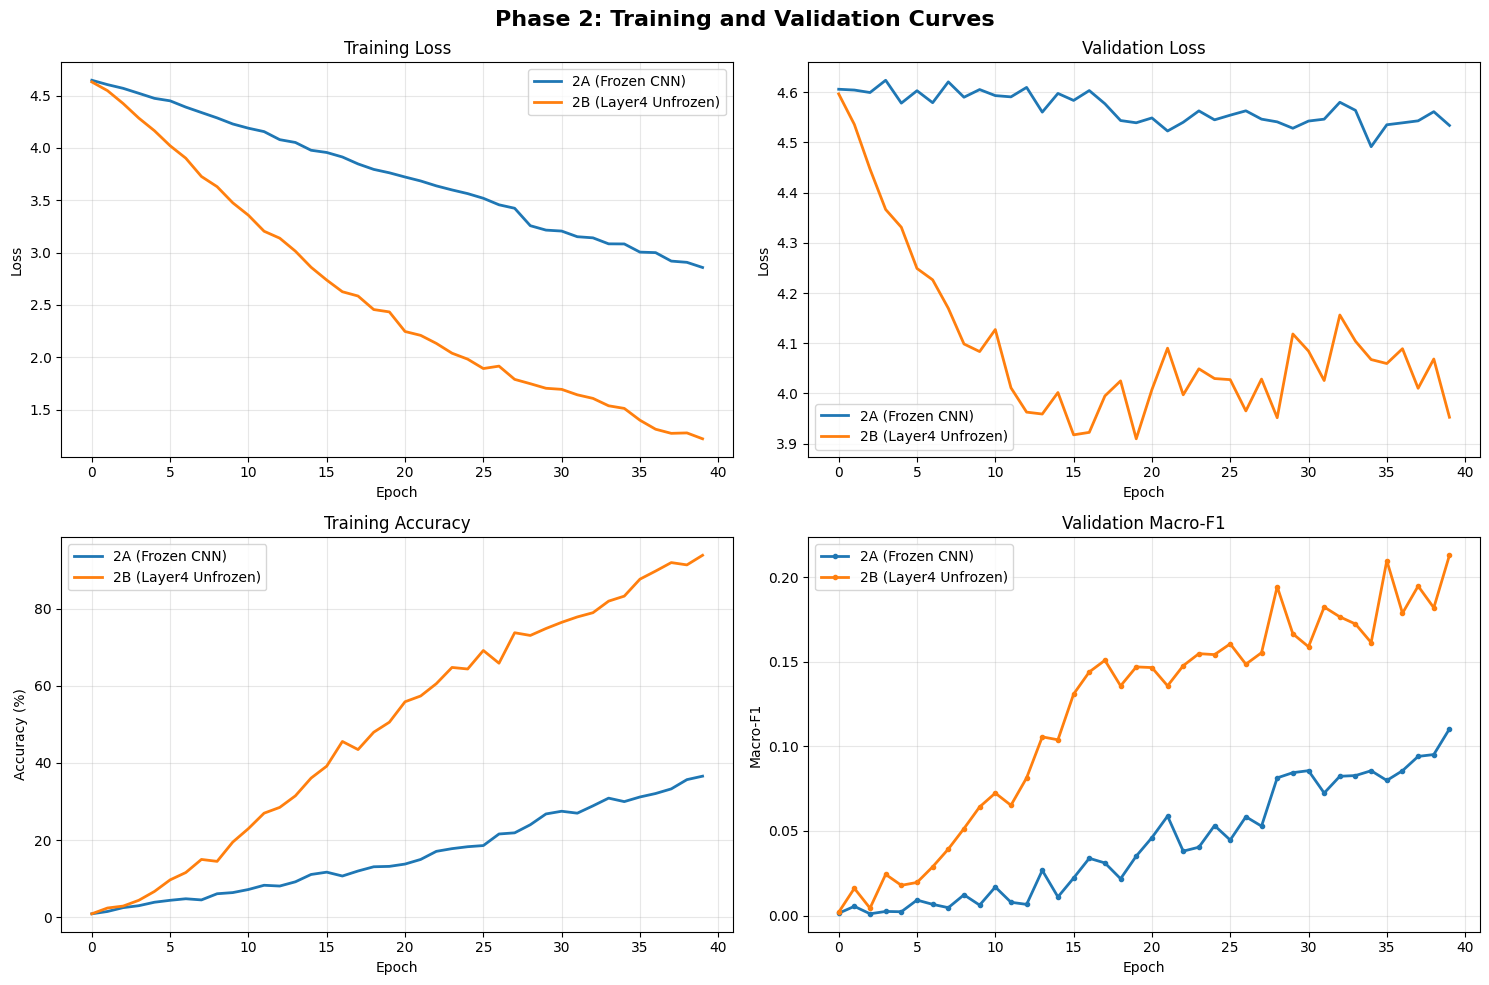

In [12]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Phase 2: Training and Validation Curves', fontsize=16, fontweight='bold')

# Plot 1: Training Loss
ax = axes[0, 0]
for history, name in zip(all_histories, model_names):
    ax.plot(history['train_loss'], label=name, linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Validation Loss
ax = axes[0, 1]
for history, name in zip(all_histories, model_names):
    ax.plot(history['val_loss'], label=name, linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Training Accuracy
ax = axes[1, 0]
for history, name in zip(all_histories, model_names):
    ax.plot(history['train_acc'], label=name, linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Training Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Validation F1
ax = axes[1, 1]
for history, name in zip(all_histories, model_names):
    ax.plot(history['val_f1'], label=name, linewidth=2, marker='o', markersize=3)
ax.set_xlabel('Epoch')
ax.set_ylabel('Macro-F1')
ax.set_title('Validation Macro-F1')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGS_DIR / 'phase2_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()


 ## 13. Test Set Evaluation

In [13]:
print("\n" + "="*80)
print(f"TEST SET EVALUATION - {best_model_name}")
print("="*80)

# Load best model
best_models = [(model_2a, best_model_2a, '2A'), (model_2b, best_model_2b, '2B')]
selected_model, selected_weights, selected_name = best_models[best_idx]
selected_model.load_state_dict(selected_weights)
selected_model.eval()

# Evaluate on test set
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
    selected_model, test_loader, criterion, device
)

print(f"\nTest Set Metrics:")
print(f"  Accuracy: {test_acc:.2f}%")
print(f"  Macro-F1: {test_f1:.4f}")
print(f"  Loss: {test_loss:.4f}")
print("="*80)

# Classification report
print(f"\nDetailed Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=3))



TEST SET EVALUATION - 2B (Layer4 Unfrozen)



Test Set Metrics:
  Accuracy: 4.00%
  Macro-F1: 0.0312
  Loss: 6.6706

Detailed Classification Report:
              precision    recall  f1-score   support

    accident      0.000     0.000     0.000         3
      africa      0.667     1.000     0.800         2
         all      0.250     0.500     0.333         2
       apple      0.000     0.000     0.000         1
  basketball      0.500     0.500     0.500         2
         bed      0.000     0.000     0.000         2
      before      0.000     0.000     0.000         3
        bird      0.000     0.000     0.000         2
    birthday      0.500     0.500     0.500         2
       black      0.000     0.000     0.000         3
        blue      0.500     0.500     0.500         2
        book      0.000     0.000     0.000         2
     bowling      0.000     0.000     0.000         2
       brown      0.000     0.000     0.000         2
         but      0.000     0.000     0.000         1
         can      0.000     0.0

C:\Users\robin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\robin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\robin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

 ## 14. Confusion Matrix

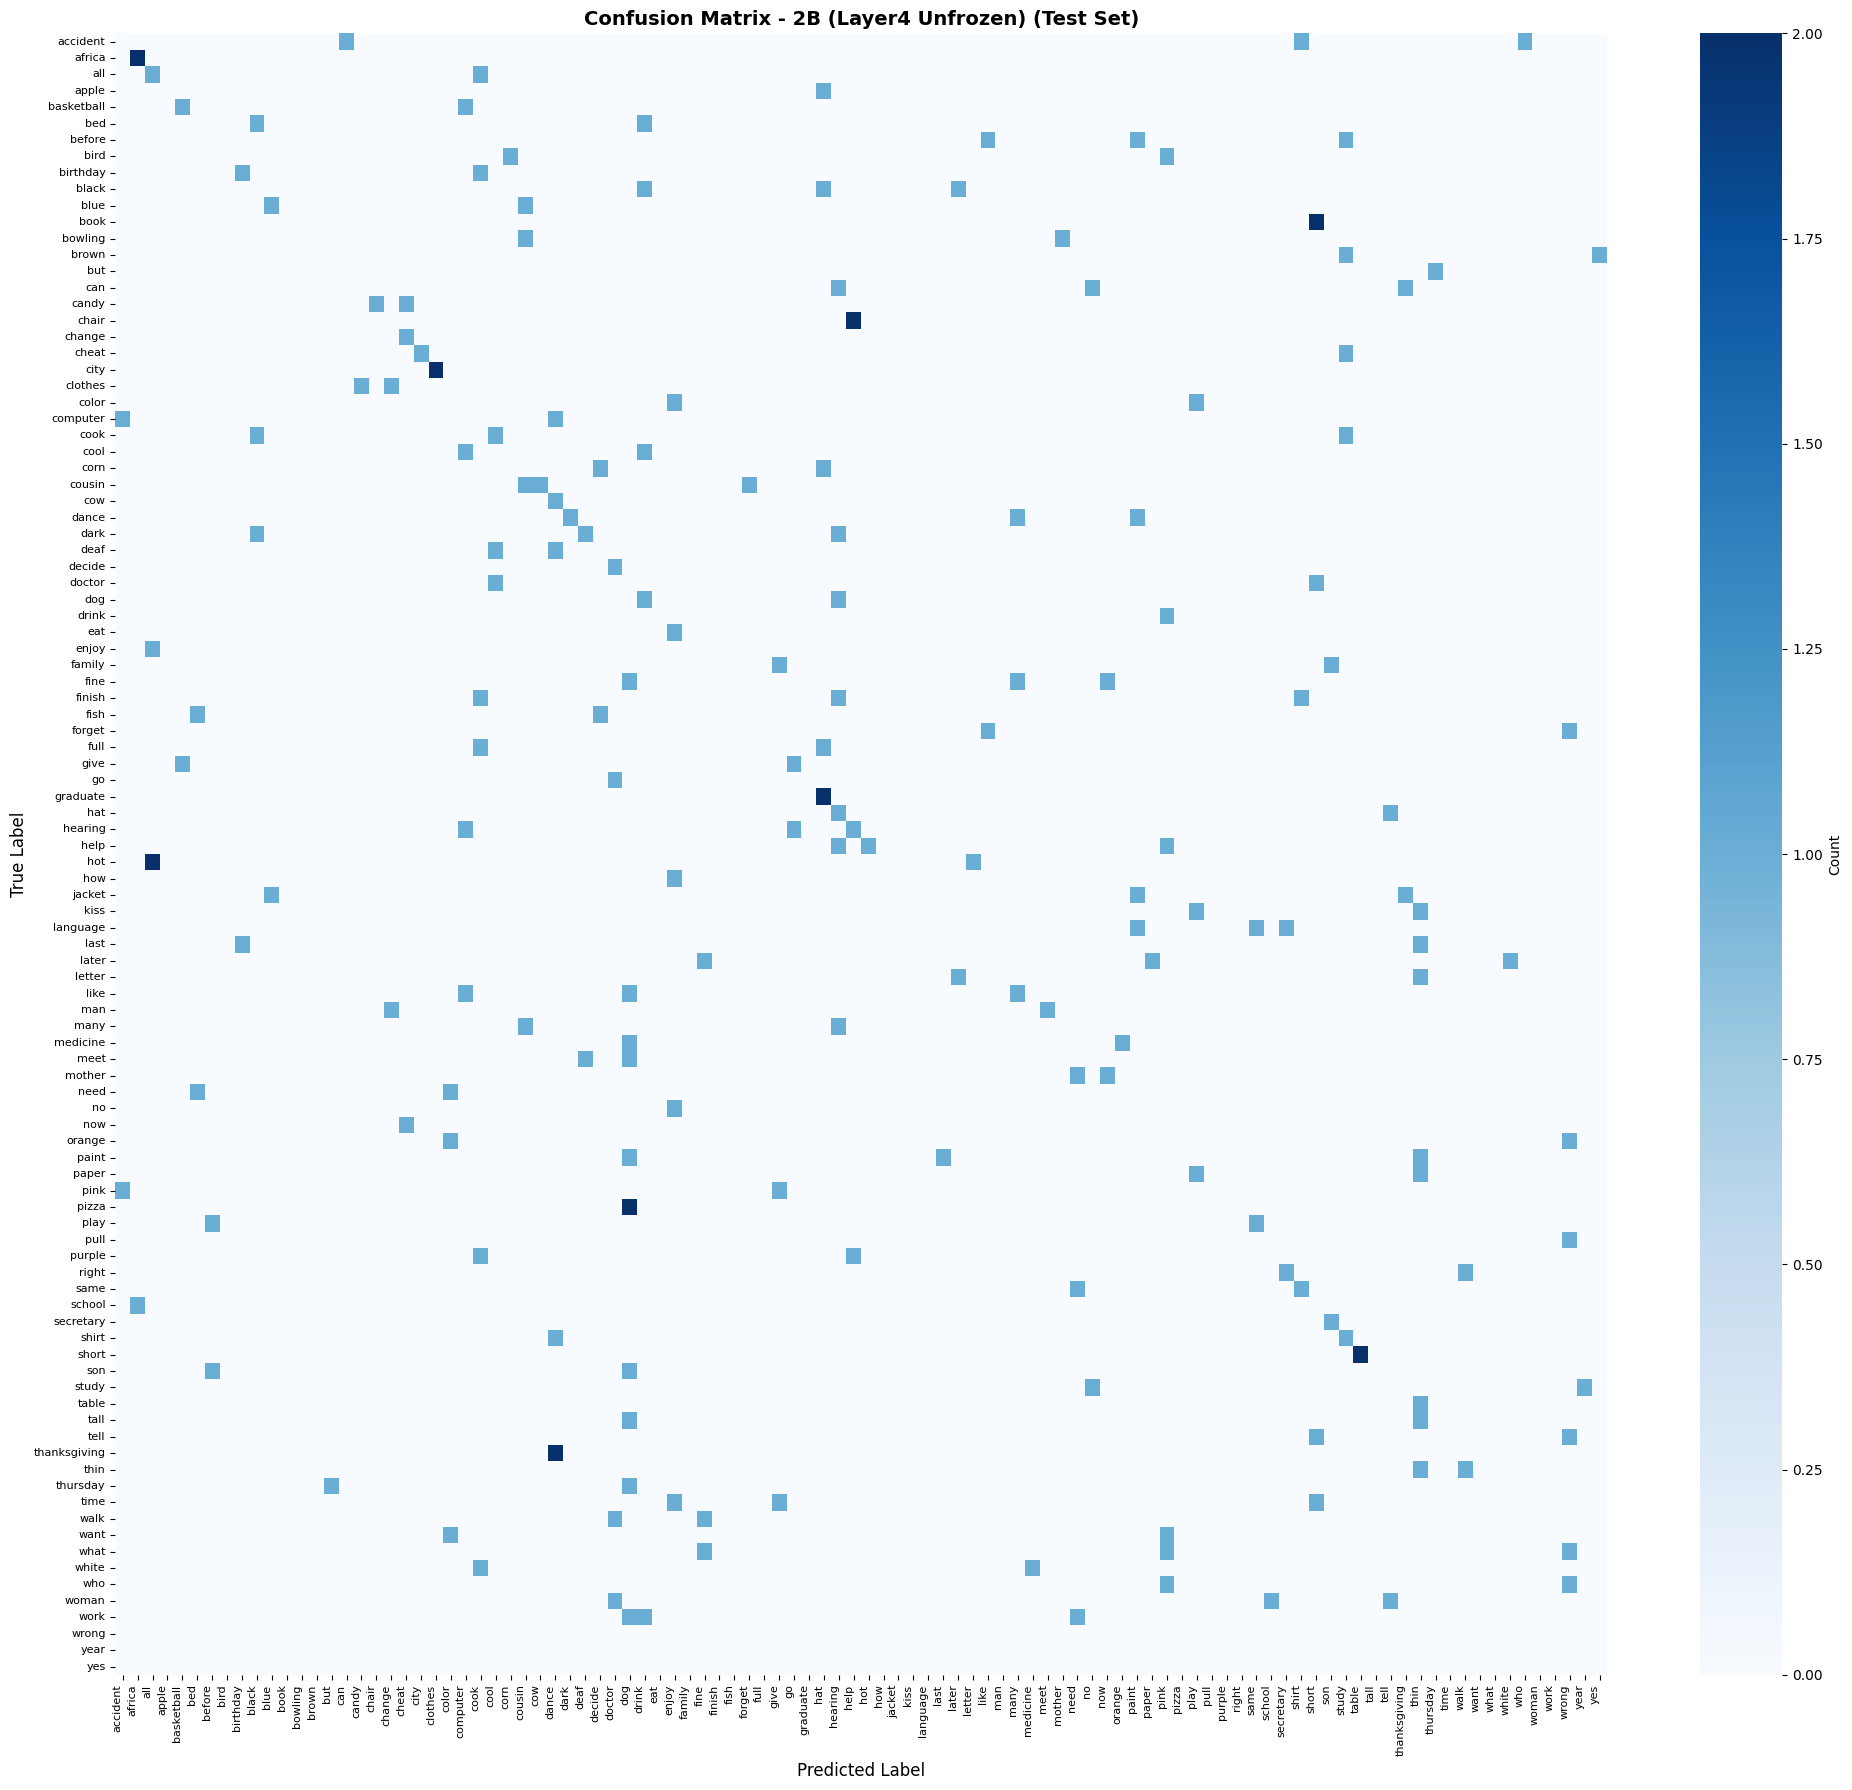

In [14]:
# Plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(FIGS_DIR / f'phase2_confusion_matrix_{selected_name}_test.png', dpi=300, bbox_inches='tight')
plt.show()


 ## 15. Summary

In [15]:
print("\n" + "="*80)
print("PHASE 2 EXPERIMENT SUMMARY")
print("="*80)
print("\nKey Findings:")
print(f"1. Best performing model: {best_model_name}")
print(f"2. Best validation F1 score: {results_summary[best_idx]['Best Val F1']:.4f}")
print(f"3. Test set accuracy: {test_acc:.2f}%")
print(f"4. Test set F1 score: {test_f1:.4f}")
print("\nComparison:")
for result in results_summary:
    print(f"  - {result['Model']}: F1={result['Best Val F1']:.4f}, Acc={result['Best Val Acc (%)']:.2f}%")

print("\n" + "="*80)
print("Files saved:")
print(f"  - Checkpoints: {CHECKPOINT_DIR}")
print(f"  - Figures: {FIGS_DIR}")
print(f"    - phase2_training_curves.png")
print(f"    - phase2_confusion_matrix_{selected_name}_test.png")
print("="*80)





PHASE 2 EXPERIMENT SUMMARY

Key Findings:
1. Best performing model: 2B (Layer4 Unfrozen)
2. Best validation F1 score: 0.2130
3. Test set accuracy: 4.00%
4. Test set F1 score: 0.0312

Comparison:
  - 2A (Frozen CNN): F1=0.1103, Acc=13.64%
  - 2B (Layer4 Unfrozen): F1=0.2130, Acc=24.38%

Files saved:
  - Checkpoints: C:\Users\robin\OneDrive\Documents\code\daen429-project\checkpoints
  - Figures: C:\Users\robin\OneDrive\Documents\code\daen429-project\figs
    - phase2_training_curves.png
    - phase2_confusion_matrix_2B_test.png
